In [1]:
# This notebook is a trial to mask raw Cordex data and extract timeseries

In [2]:
# navigate to correct location to access modules

In [3]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [4]:
# import needed packages
from acs_area_statistics import acs_regional_stats, regions
import xarray as xr

In [5]:
ds = xr.open_dataset("/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CESM2/historical/r11i1p1f1/BARPA-R/v1-r1/day/pr/v20231001/pr_AUS-15_CESM2_historical_r11i1p1f1_BOM_BARPA-R_v1-r1_day_196001-196012.nc")
ds

<xarray.Dataset> Size: 989MB
Dimensions:    (time: 365, lat: 436, lon: 777, bnds: 2)
Coordinates:
  * time       (time) object 3kB 1960-01-01 12:00:00 ... 1960-12-31 12:00:00
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float64 989MB ...
    time_bnds  (time, bnds) object 6kB ...
Attributes: (12/57)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1D.json
    productive_version:        ffe7c4c
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    ...                        ...
    history:                   Thu Nov 09 12:59:42 2023: /g/data/access/ngm/m...
    references:                https://doi.org/10.25914/z1x6-dq28
    license:                   https://doi.org/10.25914/z1x6-dq28
    acknowledgement:           The production of BARPA was supported with fun...
    date_modified:             2023-11-16T20:42:50Z
    date_metadata_modified:    2023-11-16T20:42:50Z

In [6]:
# Adjust lat and lon to correct for float problems! 
ds = ds.assign(lat = ds.lat.round(4), lon = ds.lon.round(4))
ds

<xarray.Dataset> Size: 989MB
Dimensions:    (time: 365, lat: 436, lon: 777, bnds: 2)
Coordinates:
  * time       (time) object 3kB 1960-01-01 12:00:00 ... 1960-12-31 12:00:00
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float64 989MB ...
    time_bnds  (time, bnds) object 6kB ...
Attributes: (12/57)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1D.json
    productive_version:        ffe7c4c
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    ...                        ...
    history:                   Thu Nov 09 12:59:42 2023: /g/data/access/ngm/m...
    references:                https://doi.org/10.25914/z1x6-dq28
    license:                   https://doi.org/10.25914/z1x6-dq28
    acknowledgement:           The production of BARPA was supported with fun...
    date_modified:             2023-11-16T20:42:50Z
    date_metadata_modified:    2023-11-16T20:42:50Z

In [7]:
# calculate the masks

In [8]:
%%time
mask = regions.mask_3D(ds)

CPU times: user 5.54 s, sys: 410 ms, total: 5.95 s
Wall time: 6.11 s


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/regionmask/core/mask.py:444: UserWarning: Detected overlapping regions. As of v0.11.0 these are correctly taken into account. Note, however, that a different mask is returned than with older versions of regionmask. To suppress this warning, set `overlap=True` (to restore the old, incorrect, behaviour, set `overlap=False`).
  warnings.warn(


In [9]:
%%time
# Fractional masking does not work unless the lat lons are a regular grid. 
# We must correct the lat lon grid (above) for the fractional grid to work here 
frac_mask = regions.mask_3D_frac_approx(ds)

CPU times: user 14.6 s, sys: 1.44 s, total: 16 s
Wall time: 17.6 s


In [10]:
%%time
# Apply the mask and calculate regional means for all timesteps
da_means = acs_regional_stats(ds, dims=("lat", "lon"), mask = frac_mask, how = "mean", )
da_means.squeeze()

CPU times: user 6.13 s, sys: 2.62 s, total: 8.75 s
Wall time: 9.23 s


<xarray.DataArray 'pr_mean' (time: 365, region: 10)> Size: 29kB
array([[1.27025523e-05, 7.22372717e-05, 3.02604177e-05, ...,
        1.49553794e-04, 3.05104889e-04, 8.24261260e-05],
       [1.45817072e-05, 1.33350239e-05, 4.75243541e-06, ...,
        1.45849479e-04, 1.92657471e-04, 4.95784521e-05],
       [3.09978933e-04, 4.59572767e-06, 8.24131325e-05, ...,
        4.30449161e-05, 1.59608319e-04, 6.02076670e-05],
       ...,
       [7.18448700e-05, 8.55979079e-05, 2.35343699e-04, ...,
        8.72683205e-06, 4.05778418e-05, 2.69819332e-05],
       [2.18984653e-06, 1.64249962e-05, 2.17237090e-05, ...,
        1.22205546e-10, 1.78711775e-05, 8.23395896e-06],
       [1.70505496e-06, 4.39296905e-06, 1.20845797e-05, ...,
        6.24995201e-08, 9.24477229e-06, 6.10170156e-06]])
Coordinates:
  * time     (time) object 3kB 1960-01-01 12:00:00 ... 1960-12-31 12:00:00
  * region   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs  (region) <U3 120B 'VIC' 'NT' 'TAS' 'SA' ... 'WAS' 'SQ' 'NQ' 'AUS'
    names    (region) <U23 920B 'Victoria' 'Northern Territory' ... 'Australia'

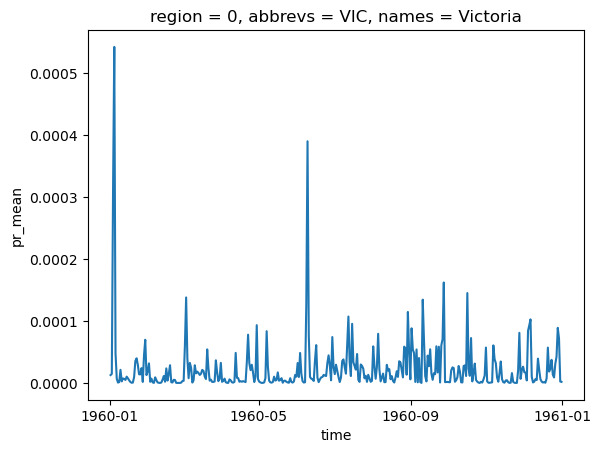

In [11]:
# Plot the timeseries of one of the regions
da_means.sel(region = 0).plot()